# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,1.220994,1.0
1,2.718022,1.0
2,1.508991,1.0
3,1.416992,1.0
4,1.456991,1.0
...,...,...
995,3.338977,-1.0
996,2.619029,1.0
997,1.330993,1.0
998,1.332993,1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model
Simplest usage of HSSM, only data needs to be provided.

In [3]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

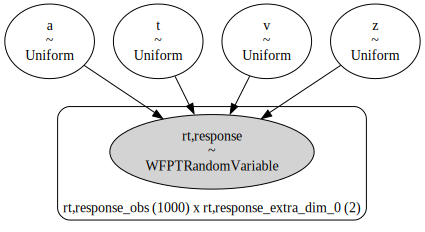

In [4]:
simple_ddm_model.graph()

In [7]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, t, z, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

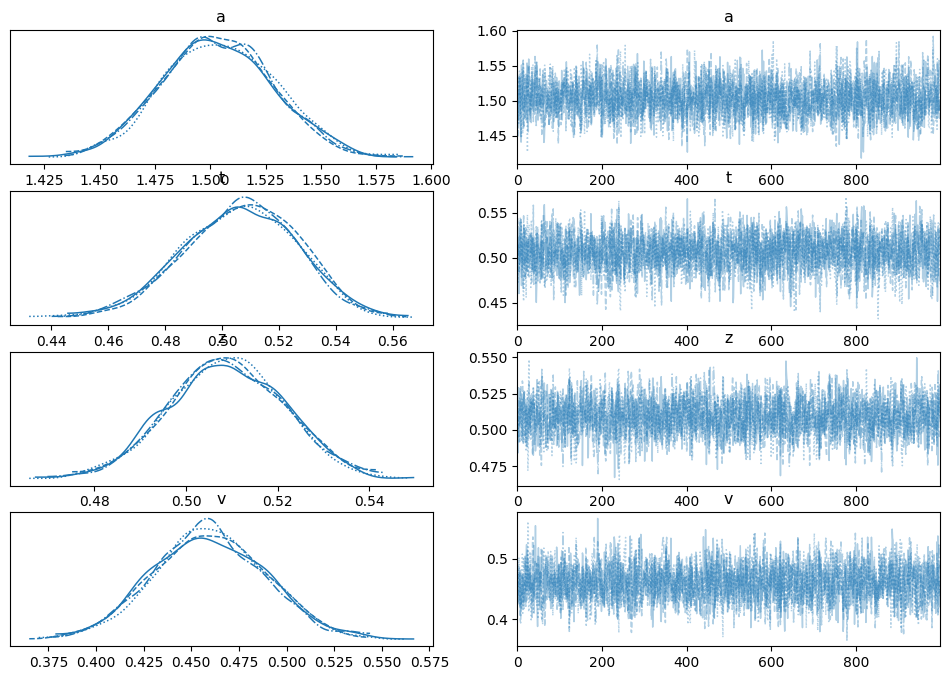

In [8]:
az.plot_trace(simple_ddm_model.traces);

In [9]:
az.summary(simple_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.504,0.025,1.455,1.549,0.001,0.0,2342.0,2758.0,1.0
t,0.506,0.020,0.467,0.541,0.000,0.0,2072.0,2631.0,1.0
z,0.509,0.013,0.486,0.533,0.000,0.0,2393.0,2564.0,1.0
v,0.460,0.030,0.406,0.517,0.001,0.0,2303.0,2796.0,1.0


In [10]:
simple_ddm_model.sample_posterior_predictive(data=dataset.iloc[:10, :])

[[[[ 3.49227381  1.        ]
   [ 1.42629993  1.        ]
   [ 2.06032515  1.        ]
   ...
   [ 1.94831991  1.        ]
   [ 2.21633244  1.        ]
   [ 1.60730386  1.        ]]

  [[ 1.90746284  1.        ]
   [ 2.72147703  1.        ]
   [ 1.39744639  1.        ]
   ...
   [ 2.80447102  1.        ]
   [ 1.48244524  1.        ]
   [ 3.5014205   1.        ]]

  [[ 3.30389166 -1.        ]
   [ 6.06869125  1.        ]
   [ 1.78791392  1.        ]
   ...
   [ 2.11192894 -1.        ]
   [ 1.83991635  1.        ]
   [ 1.87491798  1.        ]]

  ...

  [[ 1.29598904  1.        ]
   [ 1.58498859  1.        ]
   [ 1.72999549 -1.        ]
   ...
   [ 2.57902908 -1.        ]
   [ 1.34998834  1.        ]
   [ 4.32090282  1.        ]]

  [[ 5.46472883  1.        ]
   [ 1.4838953   1.        ]
   [ 0.77490437  1.        ]
   ...
   [ 1.44089592  1.        ]
   [ 2.01091719  1.        ]
   [ 2.16592455  1.        ]]

  [[ 2.04135227  1.        ]
   [ 1.65233397  1.        ]
   [ 6.67107439 -1. 

In [17]:
simple_ddm_model.traces.posterior_predictive

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000, rt,response_obs: 10,
                      rt,response_dim: 2)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * rt,response_obs  (rt,response_obs) int64 0 1 2 3 4 5 6 7 8 9
  * rt,response_dim  (rt,response_dim) int64 0 1
Data variables:
    rt,response      (chain, draw, rt,response_obs, rt,response_dim) float32 ...
Attributes:
    modeling_interface:          bambi
    modeling_interface_version:  0.12.0.dev

## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [9]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

,rt,response
0,1.689000,1.0
1,0.867999,-1.0
2,2.263026,-1.0
3,2.094018,1.0
4,1.316993,1.0
...,...,...
995,2.588031,1.0
996,1.569994,1.0
997,0.904998,1.0
998,2.036016,-1.0


This creates a default angle model using pytensor

In [10]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 3.0)	bounds: (0.3, 3.0)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0010000000474974513, upper: 2.0)	bounds: (0.001, 2.0)
theta ~ Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)	bounds: (-0.1, 1.3)

In [11]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, z, t, theta, v]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 65 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

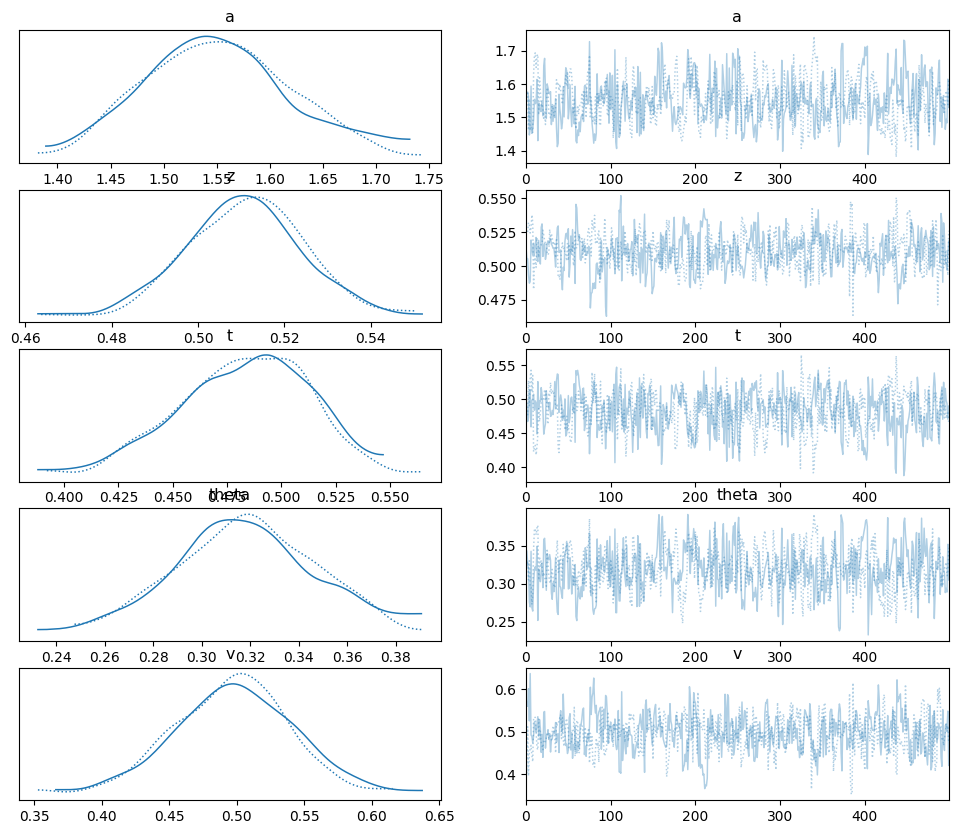

In [12]:
az.plot_trace(angle_model.traces);

#### Sampling the angle model using jax

In [13]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

Compiling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.681973
Sampling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
sample: 100%|█████████████████████████████████████████| 2000/2000 [00:38<00:00, 52.18it/s, 31 steps of size 1.62e-01. acc. prob=0.96]
/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(se

Sampling time =  0:02:26.240134
Transforming variables...
Transformation time =  0:00:00.094555


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [14]:
az.summary(angle_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.558,0.067,1.437,1.688,0.002,0.001,1265.0,1070.0,1.0
z,0.511,0.013,0.486,0.535,0.000,0.000,1769.0,2230.0,1.0
t,0.480,0.030,0.422,0.536,0.001,0.001,1455.0,1056.0,1.0
theta,0.321,0.029,0.266,0.374,0.001,0.001,1341.0,1435.0,1.0
v,0.495,0.043,0.415,0.576,0.001,0.001,1724.0,2064.0,1.0


In [15]:
simple_ddm_model.sample_posterior_predictive(data=dataset_lan.iloc[:10, :])

Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * rt,response_obs  (rt,response_obs) int64 0 1 2 3 4 5 6 7 8 9
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * rt,response_obs  (rt,response_obs) int64 0 1 2 3 4 5 6 7 8 9
  * rt,response_dim  (rt,response_dim) int64 0 1


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [16]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.2, 0.5, size=1000)
y = np.random.uniform(0.1, 0.4, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [17]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [18]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,2.208024,1,0.464760,0.214812
1,0.838999,1,0.459729,0.395442
2,1.090996,1,0.334700,0.310067
3,3.697951,1,0.384255,0.111282
4,1.792004,1,0.318323,0.382927
...,...,...,...,...
995,4.254910,-1,0.360945,0.398096
996,1.475991,1,0.358669,0.164192
997,1.800005,1,0.475031,0.299937
998,2.638027,1,0.409973,0.345071


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [19]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

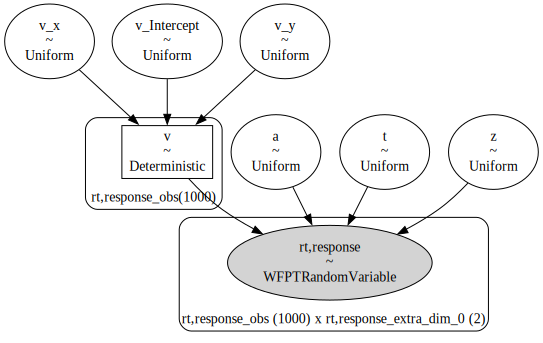

In [20]:
model_reg_v.graph()

In [22]:
trace_reg_v = model_reg_v.sample(cores=1, chains=2, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [z, t, a, v_Intercept, v_x, v_y]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>]],
      dtype=object)

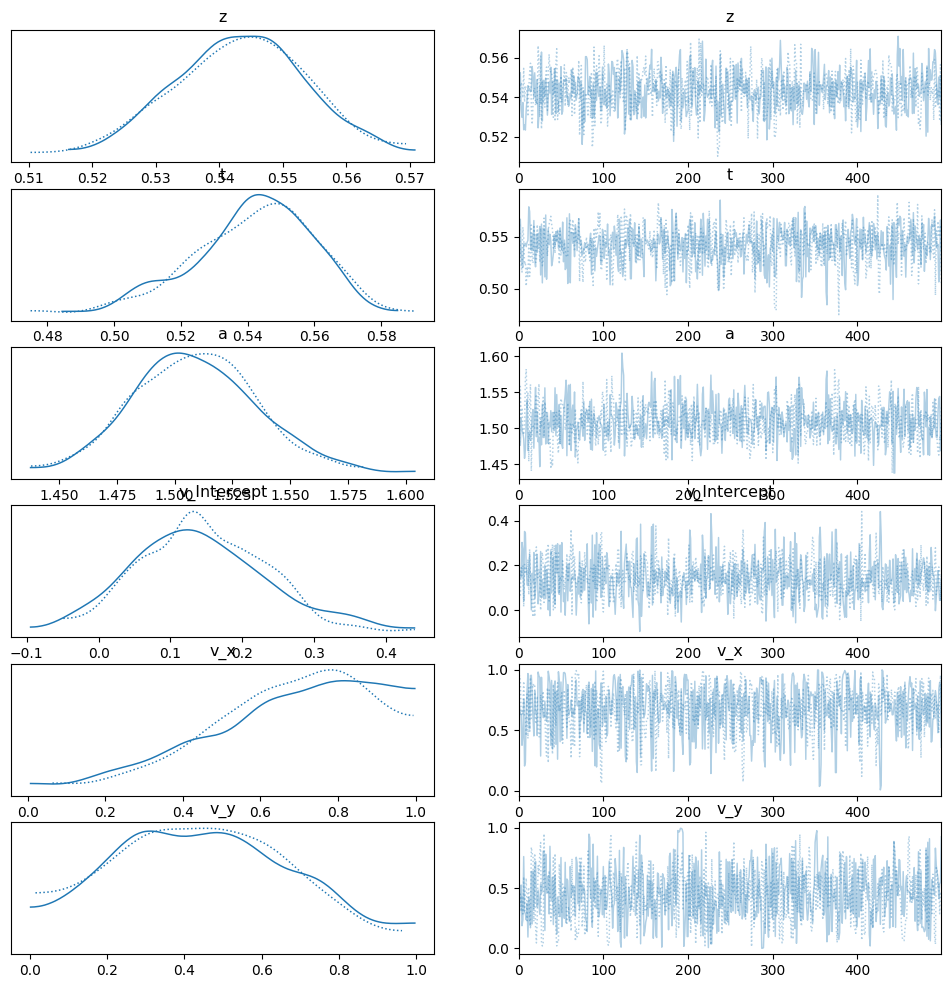

In [23]:
az.plot_trace(model_reg_v.traces)

In [24]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.543,0.010,0.523,0.562,0.000,0.000,889.0,657.0,1.0
t,0.542,0.018,0.505,0.572,0.001,0.000,998.0,797.0,1.0
a,1.509,0.026,1.463,1.561,0.001,0.001,963.0,606.0,1.0
v_Intercept,0.143,0.089,-0.031,0.297,0.003,0.002,1135.0,756.0,1.0
v_x,0.678,0.204,0.314,0.993,0.007,0.005,912.0,618.0,1.0
v_y,0.446,0.221,0.036,0.818,0.008,0.006,769.0,480.0,1.0


In [25]:
new_data = pd.DataFrame(
    {
        "x": np.random.uniform(0.2, 0.5, size=10),
        "y": np.random.uniform(0.1, 0.4, size=10),
    }
)

In [26]:
posterior = 

In [ ]:
az.plot_trace(posterior)

In [ ]:
model_reg_v.traces.posterior

#### Case 2: adding initval to priors along with lower and upper.

- v is a parent
- x is a feature from the dataset_reg_v

Adding initval is optional.

In [ ]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [ ]:
hssm_include_val

In [ ]:
samples_two = hssm_include_val.sample()

In [ ]:
az.summary(samples_two)

#### Case 3: not specifying parent v in the include parameter. 

The parent is v by default, specifying it is not mandatory. 

In [ ]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [ ]:
hssm_include_val

In [ ]:
hssm_include_val.graph()

In [ ]:
samples_three = hssm_include_val.sample(draws=500, tune=500)

In [ ]:
az.summary(samples_three)

#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [ ]:
hssm_include_list.model

In [ ]:
hssm_include_list.graph()

In [ ]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [ ]:
samples_three = hssm_include_list.sample(draws=100, tune=100)